In [92]:
import os
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import pyfilaments.analysisutils as analysis
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from matplotlib import rc

from pyfilaments.activeFilaments import activeFilament

#rcParams['axes.titlepad'] = 20 
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
### for Palatino and other serif fonts use:
##rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=False)
#plt.rc('font', family='serif')

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

%matplotlib notebook

In [93]:
# file = '/home/deepak/Dropbox/LacryModeling/ModellingResults/BenchmarkingResults/2021-05-30/SimResults_Np_32_Shape_line_kappa_hat_1250_k_5000_b0_2.1_F_-0.05_S_0_D_0_activityTime_20000_simType_cantilever/SimResults_00.hdf5'
# file = '/home/deepak/Dropbox/LacryModeling/ModellingResults/BenchmarkingResults/2021-05-30/SimResults_Np_32_Shape_line_kappa_hat_1250_k_5000_b0_2.1_F_-0.01_S_0_D_0_activityTime_20000_simType_cantilever/SimResults_00.hdf5'
file = '/home/deepak/Dropbox/LacryModeling/ModellingResults/BenchmarkingResults/2021-05-30/SimResults_Np_64_Shape_line_kappa_hat_625_k_10000_b0_1.05_F_-0.1_S_0_D_0_activityTime_20000_simType_cantilever/SimResults_00.hdf5'

filament = analysis.analysisTools(file = file)

folder, *rest = os.path.split(file)

df_metadata = pd.read_csv(os.path.join(folder, 'metadata.csv'))

df_metadata

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile not found!
Time step: 39.885714285714286
No:of particles : 64
No:of time points : 350
Root path:  /home/deepak/Dropbox/LacryModeling/ModellingResults/BenchmarkingResults/2021-05-30/SimResults_Np_64_Shape_line_kappa_hat_625_k_10000_b0_1.05_F_-0.1_S_0_D_0_activityTime_20000_simType_cantilever
Data file SimResults_00.hdf5


,N particles,radius,bond length,spring constant,kappa_hat,force strength,stresslet strength,potDipole strength,simulation type,boundary condition 0,boundary condition 1,activity time scale,viscosity,Simulation time,CPU time (s)
0,64,0.5,1.05,10000,625.0,-0.1,0,0,cantilever,clamped,free,20000,0.166667,13960.0,77152.160267


In [94]:
ss_shape = filament.R[-1,:]
y_simulation = ss_shape[filament.Np:2*filament.Np]
tip_deflection = abs(y_simulation[-1])

<IPython.core.display.Javascript object>


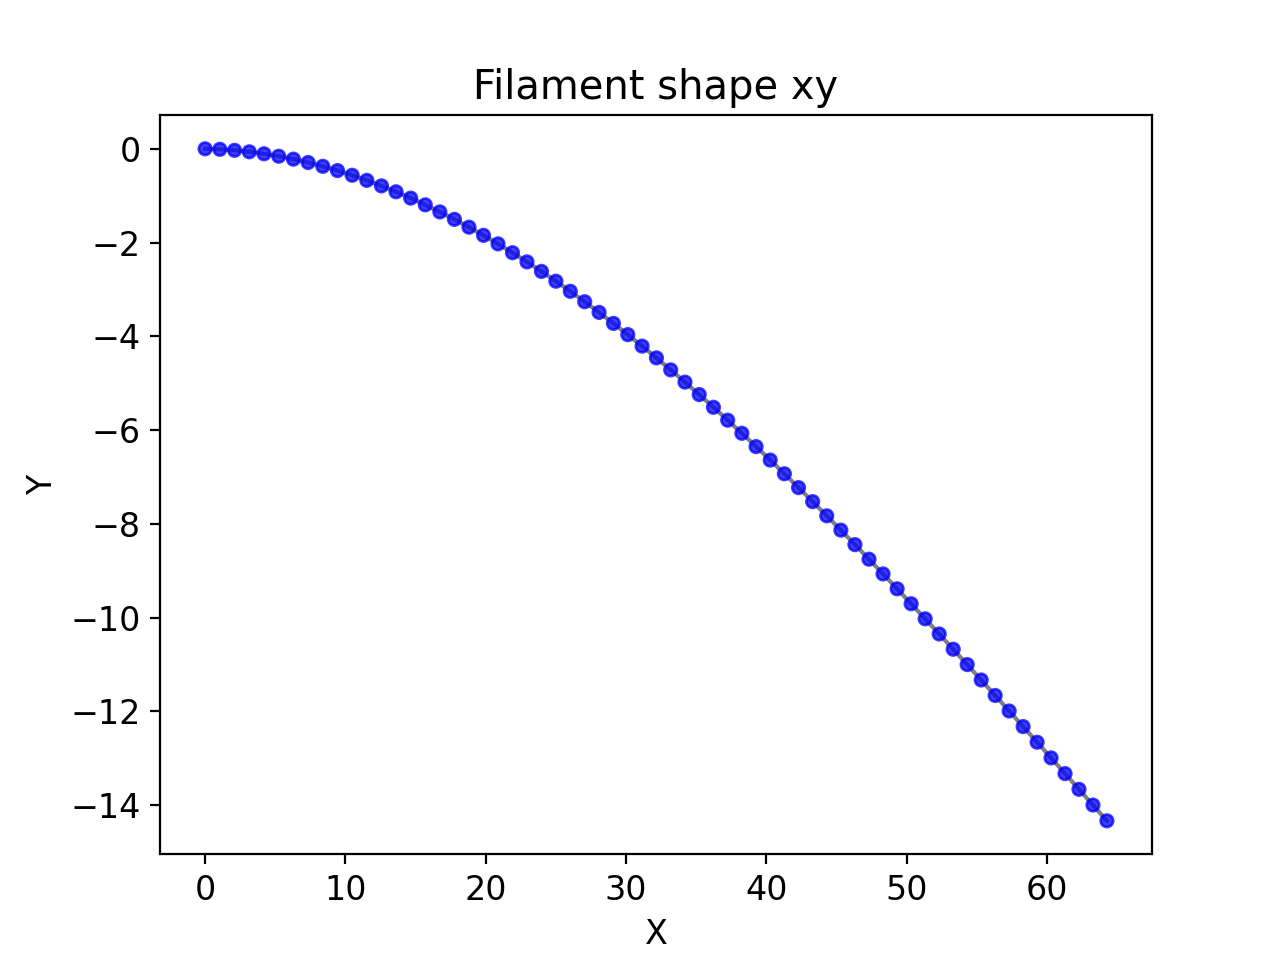

In [95]:
filament.plotFilament(ss_shape)

In [96]:
# Euler Bernoulli theory for cantilevered beam
# y = - F L/(2 E I) s^2 + (F/(6 EI))s^3
# F: force at the tip, EI = bending modulus, L: rod length, s: arc length 
a = df_metadata['radius'][0]
Np = df_metadata['N particles'][0]
b0 = df_metadata['bond length'][0]
kappa_hat = df_metadata['kappa_hat'][0]
k = df_metadata['spring constant'][0]
F = df_metadata['force strength'][0]



EI = b0*kappa_hat
L = (Np - 1)*b0
A = np.pi*(a**2) # Cross-sectional area of filament
I = np.pi*(a**4)/4
pr = 0.5
G = kappa_hat*b0/(2*I*(1 + pr)) # Shear modulus
alpha_c = 4/3.0 # Timoshenko shear factor

euler_bernoulli = lambda s: -s**2*F*L/(2*EI) + s**3*(F/(6*EI))
timoshenko = lambda s: -s*F/(alpha_c*A*G) - s**2*F*L/(2*EI) + s**3*(F/(6*EI))

In [97]:
s_array = np.array([ii*b0 for ii in range(Np)])
y_array = -np.array([euler_bernoulli(s) for s in s_array])
y_timoshenko = -np.array([timoshenko(s) for s in s_array])

<IPython.core.display.Javascript object>


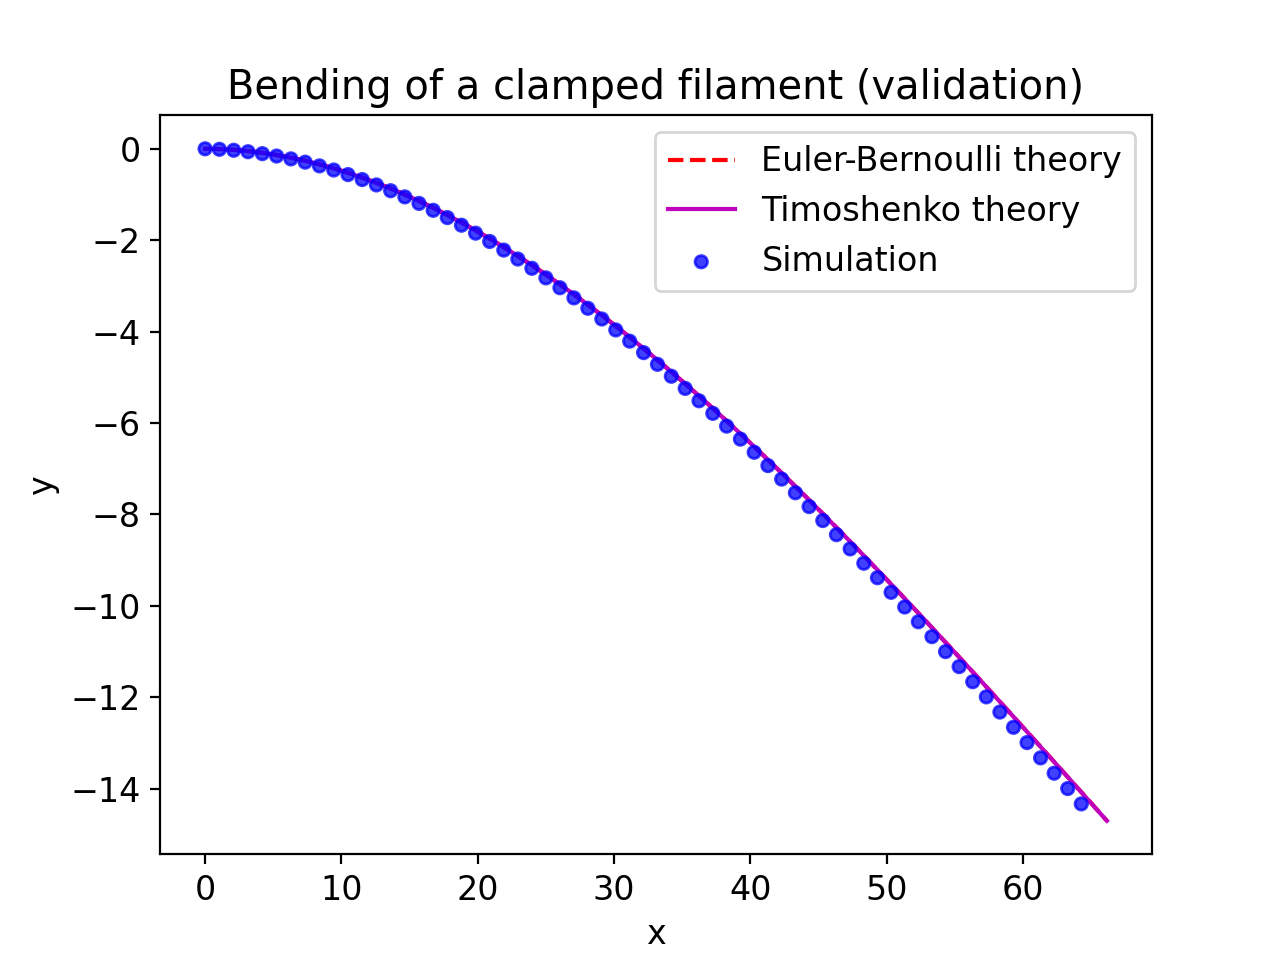

In [100]:
# Compare theory and simulation

plt.figure()
plt.scatter(ss_shape[0:filament.Np], ss_shape[filament.Np:2*filament.Np], 20, c = filament.particle_colors, alpha = 0.75, zorder = 20, label = 'Simulation')
plt.plot(s_array, y_array, 'r--', label = 'Euler-Bernoulli theory')
plt.plot(s_array, y_timoshenko, 'm-', label = 'Timoshenko theory')
plt.legend()
plt.ylabel('y')
plt.xlabel('x')
plt.title('Bending of a clamped filament (validation)')
plt.savefig('BendingFilamentValidation_Np_{}_kappa_hat_{}_b0_{}_F_{}.png'.format(Np, kappa_hat, b0, F))
plt.show()

In [99]:
# Error between theory and simulation
rel_error = np.mean((y_simulation - y_array)**2)**(1/2)/(np.mean(y_array**2))**(1/2)

print('Relative error: {} %'.format(rel_error*100))

Relative error: 2.0075224355959422 %


In [56]:
y_shear

array([-0.0e+00, -3.0e-06, -6.0e-06, -9.0e-06, -1.2e-05, -1.5e-05,
       -1.8e-05, -2.1e-05, -2.4e-05, -2.7e-05, -3.0e-05, -3.3e-05,
       -3.6e-05, -3.9e-05, -4.2e-05, -4.5e-05, -4.8e-05, -5.1e-05,
       -5.4e-05, -5.7e-05, -6.0e-05, -6.3e-05, -6.6e-05, -6.9e-05,
       -7.2e-05, -7.5e-05, -7.8e-05, -8.1e-05, -8.4e-05, -8.7e-05,
       -9.0e-05, -9.3e-05])

In [57]:
EI/(alpha_c*L**2*A*G)

8.848492570805635e-05

In [81]:
G

0.3013717802860824